In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

%matplotlib inline
plt.style.use("fivethirtyeight")

In [2]:
# Load stock data
company = "BTC-USD"
start = dt.date(2015, 1, 1)
end = dt.date.today()

data = web.DataReader(company, "yahoo", start, end)
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007
2015-01-05,278.341003,265.084015,265.084015,274.473999,43962800,274.473999
...,...,...,...,...,...,...
2022-04-08,43903.019531,42183.289062,43505.136719,42287.664062,27215995394,42287.664062
2022-04-09,42786.816406,42183.253906,42282.078125,42782.136719,16050772496,42782.136719
2022-04-10,43376.378906,42021.207031,42781.089844,42207.671875,17654475582,42207.671875


In [3]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1, 1))

prediction_days = 60
future_day = 30

X_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_day):
    X_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x+future_day, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [4]:
# Build the Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # prevent overfitting
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # prediction of the next closing value

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=25, batch_size=32)

# model.save()

2022-04-12 10:56:14.887590: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/25
81/81 [==============================] - 4s 32ms/step - loss: 0.0137
Epoch 2/25
81/81 [==============================] - 3s 36ms/step - loss: 0.0062
Epoch 3/25
81/81 [==============================] - 3s 36ms/step - loss: 0.0053
Epoch 4/25
81/81 [==============================] - 3s 36ms/step - loss: 0.0056
Epoch 5/25
81/81 [==============================] - 3s 36ms/step - loss: 0.0044
Epoch 6/25
81/81 [==============================] - 3s 36ms/step - loss: 0.0046
Epoch 7/25
81/81 [==============================] - 3s 36ms/step - loss: 0.0044
Epoch 8/25
81/81 [==============================] - 3s 36ms/step - loss: 0.0043
Epoch 9/25
81/81 [==============================] - 3s 37ms/step - loss: 0.0037
Epoch 10/25
81/81 [==============================] - 3s 37ms/step - loss: 0.0038
Epoch 11/25
81/81 [==============================] - 3s 37ms/step - loss: 0.0038
Epoch 12/25
81/81 [==============================] - 3s 37ms/step - loss: 0.0038
Epoch 13/25
81/81 [==================

In [5]:
# Test the model accuracy on existing data
# Load Test Data
test_start = dt.date(2020, 1, 1) + dt.timedelta(days=-prediction_days)
test_end = dt.date.today()

test_data = web.DataReader(company, "yahoo", test_start, test_end)
actual_prices = test_data["Close"].values

total_dataset = pd.concat((data["Close"], test_data["Close"]), axis=0)

model_inputs = total_dataset[
    len(total_dataset) - len(test_data) - prediction_days :
].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


In [6]:
# Make Predictions on Test Data
X_test = []

for x in range(prediction_days, len(model_inputs)):
    X_test.append(model_inputs[x - prediction_days:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


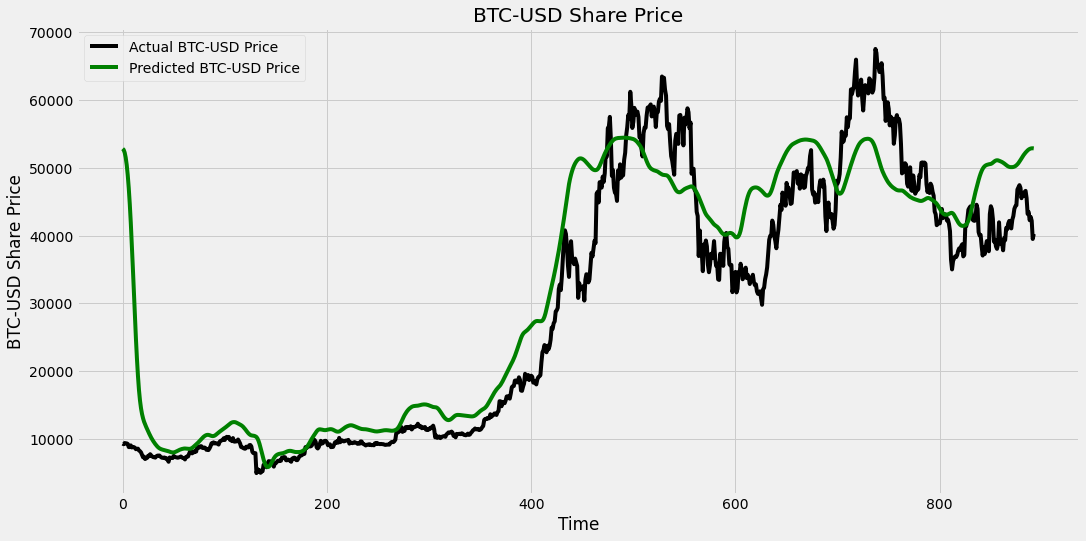

In [7]:
# Plot the test predictions
plt.figure(figsize=(16,8))
plt.plot(actual_prices, color = "black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend(loc='upper left')
plt.show()
# plt.savefig(f"./plot/{company}_LSTM_predicted.png")

In [10]:
# Predict Next Day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
print(scaler.inverse_transform(real_data[-1]))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

[[42197.515625  ]
 [42586.91796875]
 [44575.203125  ]
 [43961.859375  ]
 [40538.01171875]
 [40030.9765625 ]
 [40122.15625   ]
 [38431.37890625]
 [37075.28125   ]
 [38286.02734375]
 [37296.5703125 ]
 [38332.609375  ]
 [39214.21875   ]
 [39105.1484375 ]
 [37709.78515625]
 [43193.234375  ]
 [44354.63671875]
 [43924.1171875 ]
 [42451.7890625 ]
 [39137.60546875]
 [39400.5859375 ]
 [38419.984375  ]
 [38062.0390625 ]
 [38737.26953125]
 [41982.92578125]
 [39437.4609375 ]
 [38794.97265625]
 [38904.01171875]
 [37849.6640625 ]
 [39666.75390625]
 [39338.78515625]
 [41143.9296875 ]
 [40951.37890625]
 [41801.15625   ]
 [42190.65234375]
 [41247.82421875]
 [41077.99609375]
 [42358.80859375]
 [42892.95703125]
 [43960.93359375]
 [44348.73046875]
 [44500.828125  ]
 [46820.4921875 ]
 [47128.00390625]
 [47465.73046875]
 [47062.6640625 ]
 [45538.67578125]
 [46281.64453125]
 [45868.94921875]
 [46453.56640625]
 [46622.67578125]
 [45555.9921875 ]
 [43206.73828125]
 [43503.84765625]
 [42287.6640625 ]
 [42782.13

ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniconda/base/envs/trading_env/lib/python3.8/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/trading_env/lib/python3.8/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniconda/base/envs/trading_env/lib/python3.8/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/trading_env/lib/python3.8/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/trading_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/Caskroom/miniconda/base/envs/trading_env/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 60, 1), found shape=(None, 59, 1)


In [9]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2659.000000,2659.000000,2659.000000,2659.000000,2.659000e+03,2659.000000
mean,12671.008249,11984.232714,12343.804578,12357.034605,1.553606e+10,12357.034605
std,17087.917174,16148.739467,16649.849769,16652.954377,2.008990e+10,16652.954377
min,211.731003,171.509995,176.897003,178.102997,7.860650e+06,178.102997
25%,710.012512,688.683502,702.864502,703.182983,1.079270e+08,703.182983
50%,6735.463867,6468.859863,6599.709961,6597.549805,5.955691e+09,6597.549805
75%,11468.219238,10859.070801,11168.534180,11185.703125,2.608698e+10,11185.703125
max,68789.625000,66382.062500,67549.734375,67566.828125,3.509679e+11,67566.828125
